In [1]:
import gzip
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Data loading

In [2]:
with gzip.open('../data/wiki-RfA.txt.gz', 'rt', encoding='utf-8') as f:
    blocks = f.read().strip().split('\n\n')  # Assuming each record is separated by a blank line

data = []

# Parse each block of text into a dictionary
for block in blocks:
    record = {}
    for line in block.split('\n'):
        if line:
            key, value = line.split(':', 1)  # Split on the first colon only
            record[key.strip()] = value.strip()
    data.append(record)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

#Rename the columns
df.columns = ['source', 'target', 'vote', 'result', 'year_election', 'date_vote', 'comment']

In [3]:
df

,source,target,vote,result,year_election,date_vote,comment
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit..."
...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,"02:51, 2 Sep 2003",Support
198271,Angela,WhisperToMe,1,1,2003,"23:45, 26 Nov 2003",Support.
198272,Jiang,WhisperToMe,1,1,2003,,Support. --
198273,Pakaran,WhisperToMe,1,1,2003,"05:38, 5 Dec 2003",Support. Age has nothing to do with maturity....


## 2. Preliminary checks

### 2.1 Check the date and time of votes : 

In [4]:
# Define a function to extract date components
def extract_date_components(date_str):
    try:
        # Split the date string by the comma and space to separate time and date parts
        time_part, date_part = date_str.split(', ')
        # Split the time part by the colon to separate hours and minutes
        hour, minute = time_part.split(':')
        # Split the date part by space to separate day, month, and year
        day, month, year = date_part.split(' ')
        
        return pd.Series({
            "hour": hour,
            "minute": minute,
            "day": day,
            "month": month,
            "year_vote": year
        })
    except ValueError:
        # If there is a ValueError, return None for each component
        return pd.Series({
            "hour": None,
            "minute": None,
            "day": None,
            "month": None,
            "year_vote": None
        })

# Apply the function to each row in the 'date' column
date_components = df['date_vote'].apply(extract_date_components)

# Concatenate the new DataFrame with the original one (if needed)
new_df = pd.concat([df, date_components], axis=1)

new_df

,source,target,vote,result,year_election,date_vote,comment,hour,minute,day,month,year_vote
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.,23,13,19,April,2013
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--,01,04,20,April,2013
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.,23,43,19,April,2013
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...,00,11,20,April,2013
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit...",00,56,20,April,2013
...,...,...,...,...,...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,"02:51, 2 Sep 2003",Support,02,51,2,Sep,2003
198271,Angela,WhisperToMe,1,1,2003,"23:45, 26 Nov 2003",Support.,23,45,26,Nov,2003
198272,Jiang,WhisperToMe,1,1,2003,,Support. --,None,None,None,None,None
198273,Pakaran,WhisperToMe,1,1,2003,"05:38, 5 Dec 2003",Support. Age has nothing to do with maturity....,05,38,5,Dec,2003


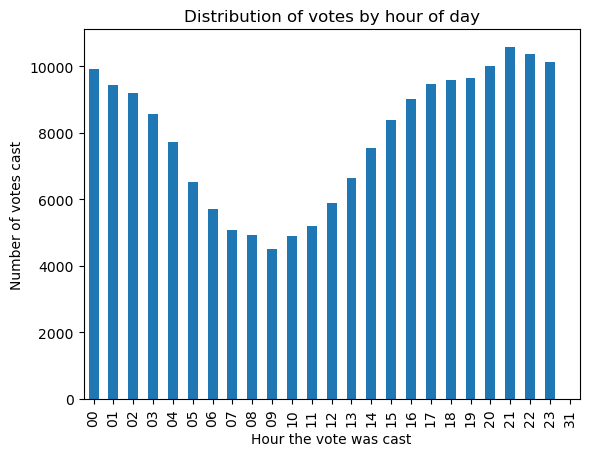

In [5]:
#Look at the distibution for the values of the hour with histogram and order the values
new_df['hour'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Hour the vote was cast')
plt.ylabel('Number of votes cast')
plt.title('Distribution of votes by hour of day')
plt.show()

We can see here that we have a voting date where the vote took place at the hour 31. 

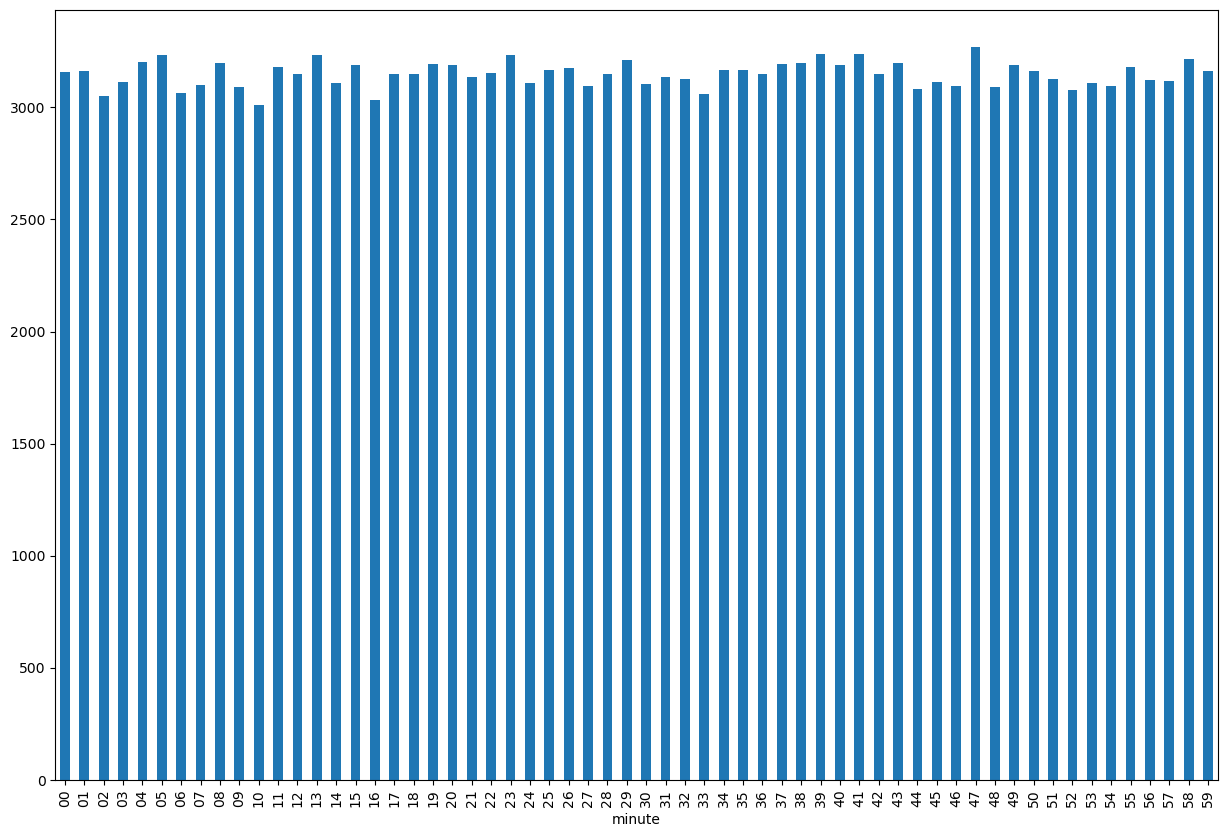

In [6]:
#Set the date to empty for the row where the hour is 31
new_df.loc[new_df['hour'] == '31', 'hour'] = ''
new_df[new_df['hour'] == '31']

#Plot the distribution of the values for the minutes wuth histogram and order the values and augment the largeur of the figure
new_df['minute'].value_counts().sort_index().plot(kind='bar' , figsize=(15,10))
plt.show()


All the values for the minutes look to be fine.

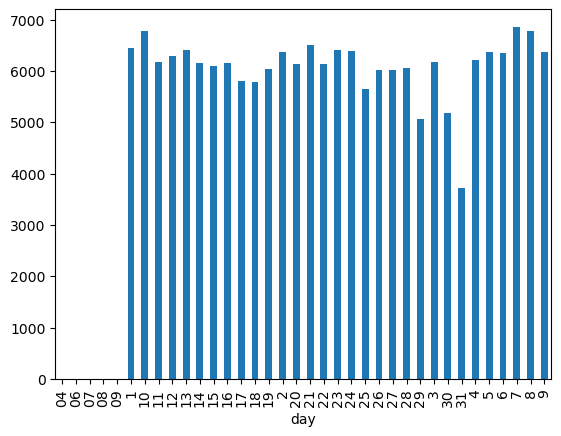

In [7]:
#Look at the distribution of the values for the days with histogram and order the values
new_df['day'].value_counts().sort_index().plot(kind='bar')
plt.show()

All values for the day look also to be ok 

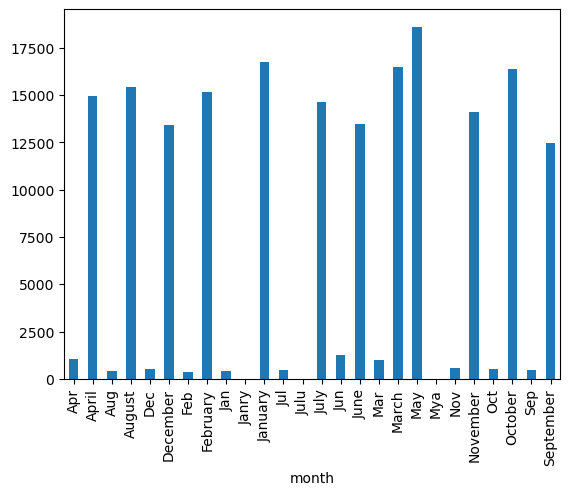

In [8]:
#Look at the distribution of the values for the months with histogram and order the values
new_df['month'].value_counts().sort_index().plot(kind='bar')
plt.show()


We can see that for specific months different values appear in the dataset. For example, for July we have Jul, Julu, July ; for the October we have Oct, October. 

In [9]:
#Map the values of the months to the full name of the month
month_map = { 
    "Apr" : "April",
    "April" : "April",
    "Aug" : "August",
    "August" : "August",
    "Dec" : "December",
    "December" : "December",
    "Feb" : "February",
    "February" : "February",
    "Jan" : "January",
    "Janry" : "January",
    "January" : "January",
    "Jul" : "July",
    "Julu" : "July",
    "July" : "July",
    "Jun" : "June",
    "June" : "June",
    "Mar" : "March",
    "March" : "March",
    "May" : "May",
    "Mya" : "May",
    "Nov" : "November",
    "November" : "November",
    "Oct" : "October",
    "October" : "October",
    "Sep" : "September",
    "September" : "September"
}

def correction_month (month) : 
    return month_map.get(month, month)

new_df['month'] = new_df['month'].apply(correction_month)
new_df

,source,target,vote,result,year_election,date_vote,comment,hour,minute,day,month,year_vote
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.,23,13,19,April,2013
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--,01,04,20,April,2013
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.,23,43,19,April,2013
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...,00,11,20,April,2013
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit...",00,56,20,April,2013
...,...,...,...,...,...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,"02:51, 2 Sep 2003",Support,02,51,2,September,2003
198271,Angela,WhisperToMe,1,1,2003,"23:45, 26 Nov 2003",Support.,23,45,26,November,2003
198272,Jiang,WhisperToMe,1,1,2003,,Support. --,None,None,None,None,None
198273,Pakaran,WhisperToMe,1,1,2003,"05:38, 5 Dec 2003",Support. Age has nothing to do with maturity....,05,38,5,December,2003


<Axes: xlabel='year_vote'>

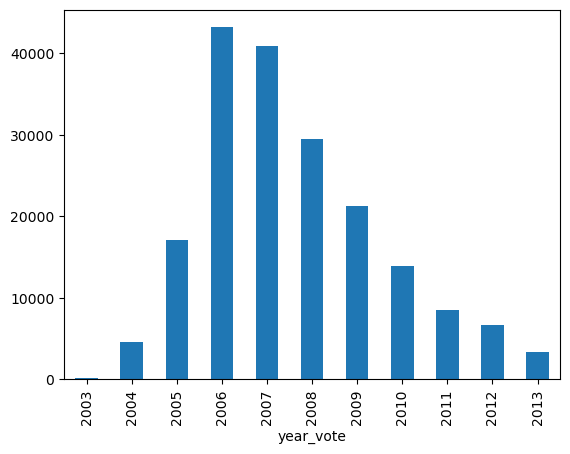

In [10]:
#Look at the distribution of the values for the years with histogram and order the values
new_df['year_vote'].value_counts().sort_index().plot(kind='bar')

The values for the years seems also to be ok. 

In [11]:
new_df['date_vote'] = pd.to_datetime(new_df['day'].astype(str) + ' ' +
                            new_df['month'] + ' ' +
                            new_df['year_vote'].astype(str) + ' ' +
                            new_df['hour'].astype(str) + ':' +
                            new_df['minute'].astype(str),
                            format='%d %B %Y %H:%M' , errors = 'coerce')

new_df.drop(['hour', 'minute', 'day', 'month', 'year_vote'], axis=1, inplace=True)
new_df

,source,target,vote,result,year_election,date_vote,comment
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit..."
...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,2003-09-02 02:51:00,Support
198271,Angela,WhisperToMe,1,1,2003,2003-11-26 23:45:00,Support.
198272,Jiang,WhisperToMe,1,1,2003,NaT,Support. --
198273,Pakaran,WhisperToMe,1,1,2003,2003-12-05 05:38:00,Support. Age has nothing to do with maturity....


In [12]:
#Look at the number of missing dates of votes
non_date_votes = new_df['date_vote'].isnull().sum()
print(f'The number of votes for which the date is missing or incorrect is {non_date_votes}')


The number of votes for which the date is missing or incorrect is 9368


### 2.2 Dive into user name source

In [13]:
#Transform the source column to string
new_df['source'] = new_df['source'].astype(str)

In [14]:
#Look at the number of unique source users
unique_voters = new_df['source'].nunique()
print(f'The number of unique voters is {unique_voters}')

#Look at the number of null values for the source
nan_source = new_df['source'].isnull().sum()
print(f'The number of voters without tags is {nan_source}')

The number of unique voters is 10417
The number of voters without tags is 0


### 2.3 Dive into target user name 

In [15]:
#Transform the source column to string
new_df['target'] = new_df['target'].astype(str)
new_df['source'] = new_df['target'].astype(str)

In [16]:
#Look at the number of unique source users
unique_electives = new_df['target'].nunique()
print(f'The number of unique users running for election is {unique_electives}')

#Look at the number of null values for the source
nan_target = new_df['target'].isnull().sum()
print(f'The number of nan values for the source is {nan_target}')

The number of unique users running for election is 3497
The number of nan values for the source is 0


### 2.4 Dive into the year_election values

count     198275
unique        11
top         2006
freq       45325
Name: year_election, dtype: object


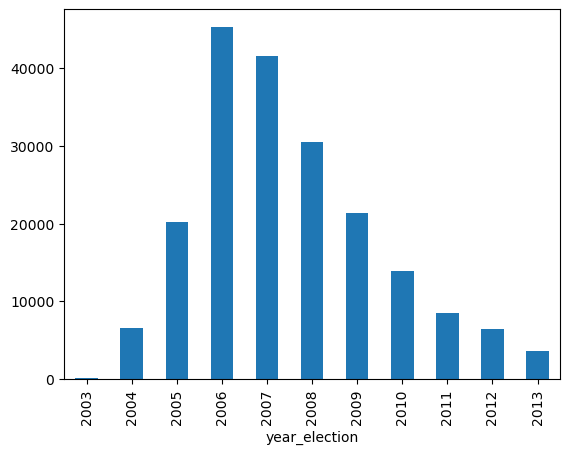

In [17]:
#Look at the distribution of the values for year_election
print(new_df['year_election'].describe())
new_df['year_election'].value_counts().sort_index().plot(kind='bar')
plt.show()

### 2.5 Dive into the vote and results values


count     198275
unique         3
top            1
freq      144451
Name: vote, dtype: object


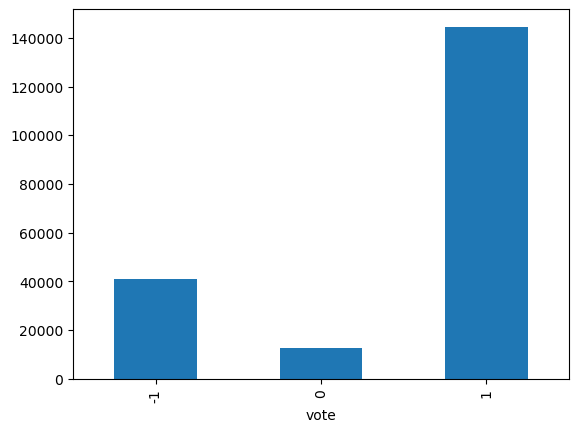

In [18]:
#Look at the distribution of the values for the vote
print(new_df['vote'].describe())
new_df['vote'].value_counts().sort_index().plot(kind='bar')
plt.show()

count     198275
unique         2
top            1
freq      123288
Name: result, dtype: object


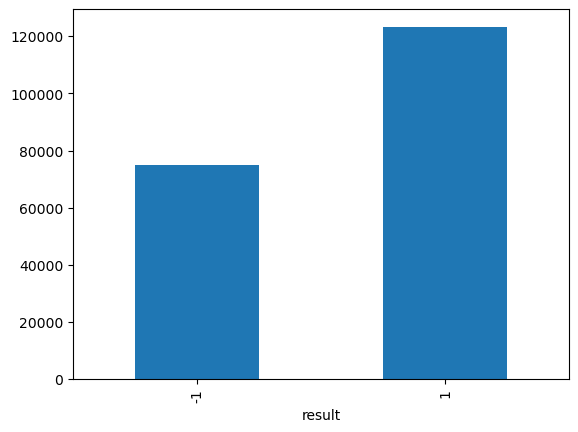

In [19]:
#Look at the distribution of the values for the result
print(new_df['result'].describe())
new_df['result'].value_counts().sort_index().plot(kind='bar')
plt.show()


## 3. Voting results analysis

In [20]:
cleaned_df = new_df.copy(deep=True)

cleaned_df['vote'] = cleaned_df['vote'].astype(int)
cleaned_df['result'] = cleaned_df['result'].astype(int)
cleaned_df['year_election'] = cleaned_df['year_election'].astype(int)

In [21]:
cleaned_df['year_election'].unique()

array([2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003])

In [22]:
#We know that 

In [76]:
#We compute here different statistics
multiple_elections = cleaned_df.groupby(['target' , 'result']).apply(lambda x : pd.Series({
    'number_of_votes' : len(x['source']), 
    'ratio_positive_votes' : x[x.vote == 1]['vote'].sum() / len(x.source), 
    'average_comment_length' : x['comment'].str.len().mean(),
    'election_year' : x['year_election'].value_counts().idxmax()
})).reset_index()

<Axes: xlabel='result', ylabel='ratio_positive_votes'>

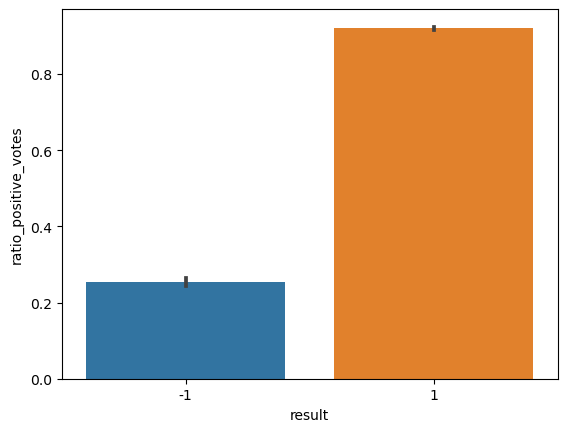

In [60]:
sns.barplot( x= 'result' , y = 'ratio_positive_votes' , data = multiple_elections)

/Users/robinjaccard/opt/anaconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


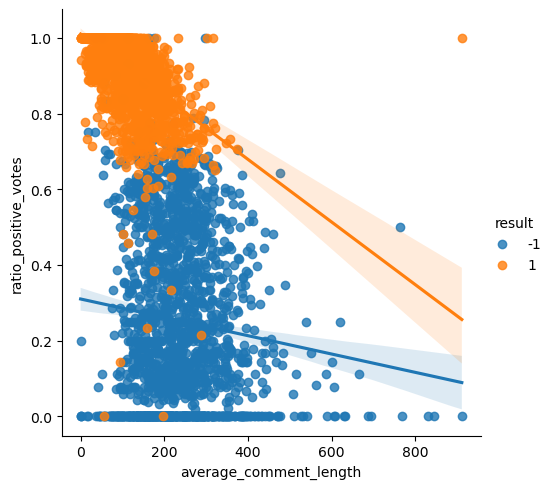

In [61]:
sns.lmplot(x = 'average_comment_length' , y = 'ratio_positive_votes' , data = multiple_elections , hue = 'result')

In [62]:
#Compute the correlation between the outcome of the vote and the ratio of positive votes
multiple_elections['result'].corr(multiple_elections['ratio_positive_votes'])

#Compute the correlation between the outcome of the vote and the average length of the comment
multiple_elections['result'].corr(multiple_elections['average_comment_length'])


-0.6062646574332258

## 4. Number of votes analysis

In [78]:
multiple_elections['election_year'].unique().sort()

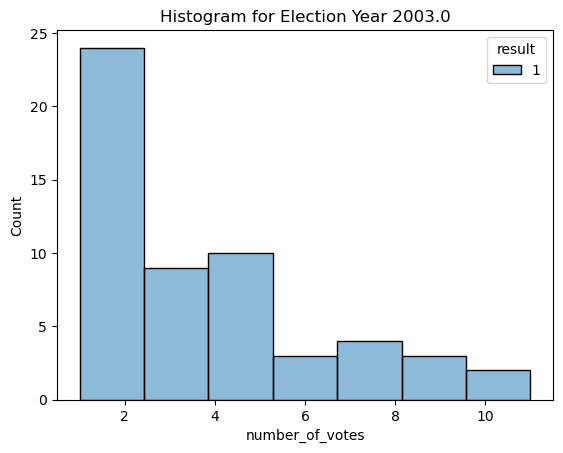

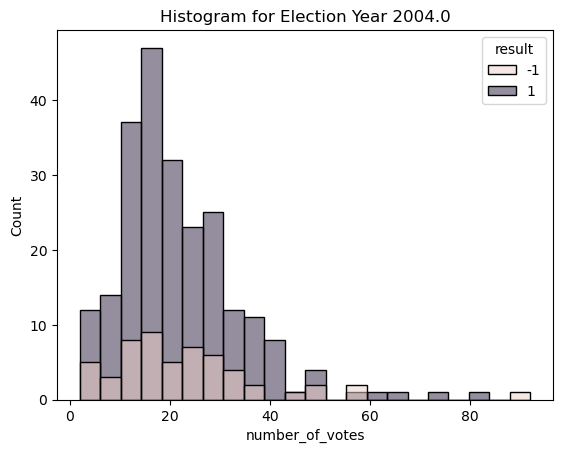

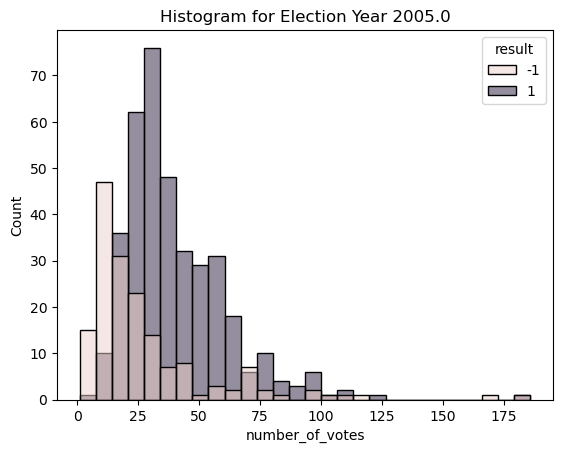

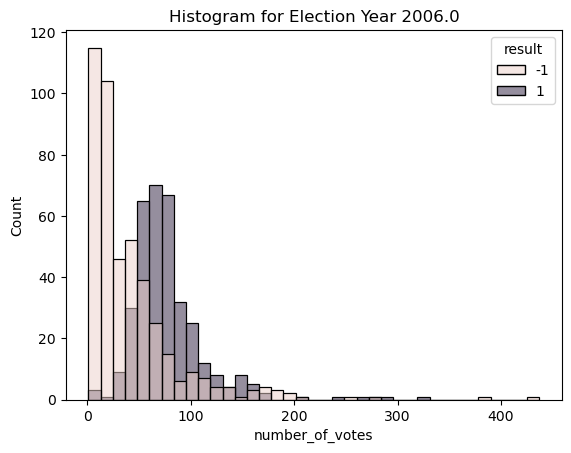

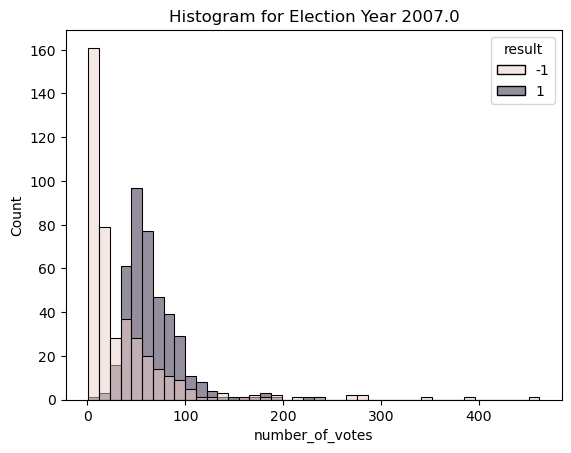

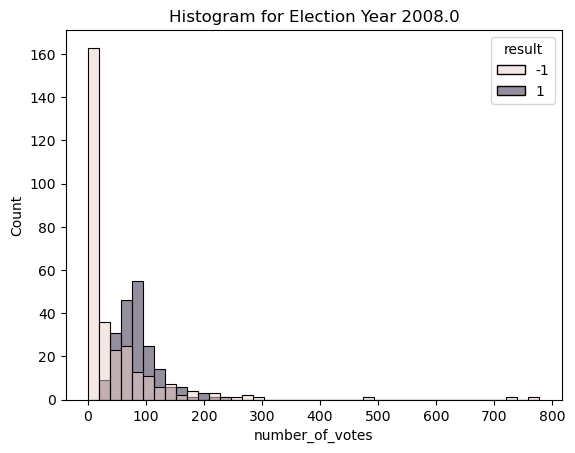

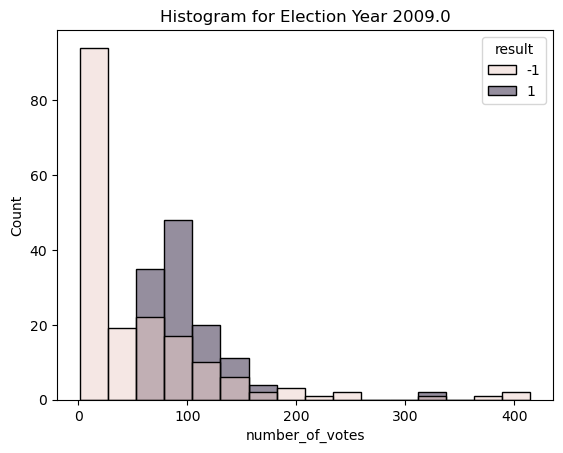

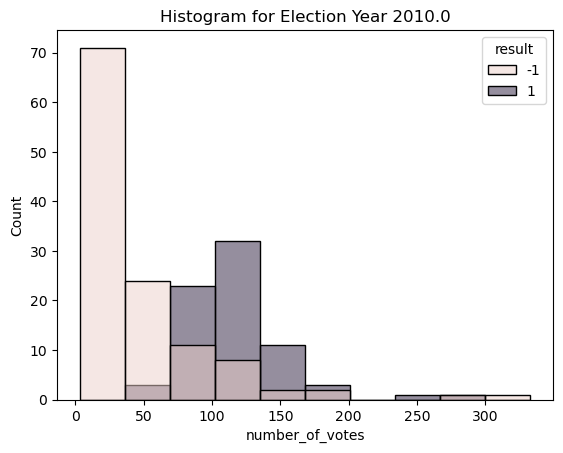

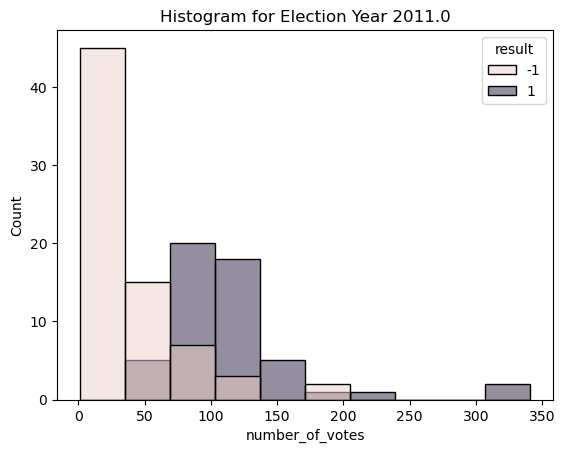

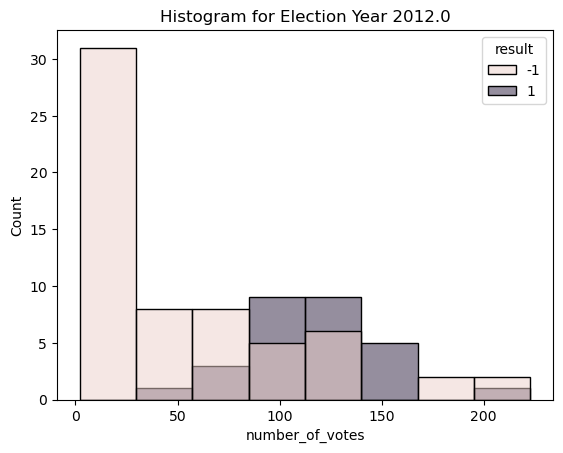

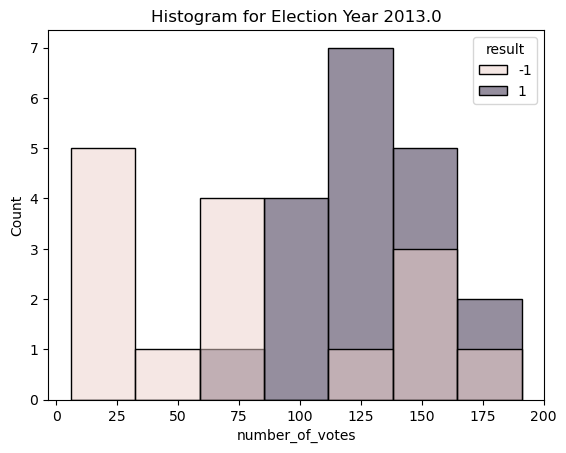

In [80]:
# Assuming 'election_year' is of type int
for year in sorted(multiple_elections['election_year'].unique()):
    data_subset = multiple_elections[multiple_elections['election_year'] == year]
    
    sns.histplot(x='number_of_votes', data=data_subset, hue='result', log_scale=(False, False))
    plt.title(f'Histogram for Election Year {year}')
    plt.show()

<Axes: xlabel='number_of_votes', ylabel='Count'>

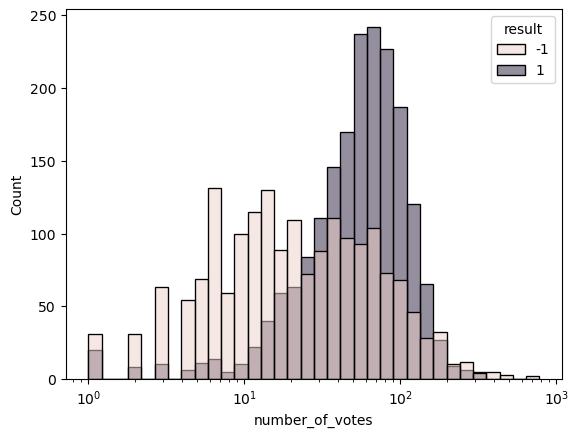

In [56]:
sns.histplot(x = 'number_of_votes', data = multiple_elections , hue = 'result', log_scale= (True, False))

In [82]:
new_df.groupby(["target", "result"])["source"].count().median()

42.0

In [83]:
new_df.groupby(["target", "result"])["source"].count().mean()

53.11411733190464